In [94]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cioppy
import numpy as np

from shapely.wkt import loads
import shapely
from shapely.geometry import Point
from shapely.geometry import LineString

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import HTML

from geopandas import GeoDataFrame
import pandas as pd

import pytz
from datetime import datetime

from ipyleaflet import *
import subprocess

Download the Polarstern AIS data from https://www.sailwx.info/shiptrack/shipposition.phtml?call=DBLK at the link **Dump ship's entire track history**

Upload the file _shipdump.html_ 

In [95]:
ais_positions = 'shipdump_DBLK.html'

Open the Polarstern entire track history and store all lines in a list

In [96]:
fin = open( ais_positions, "r" )
data_list = fin.readlines()
fin.close()


Remove the HTML tags (first four lines and last three lines)

In [97]:
del data_list[0:4]
del data_list[-3:]

In [105]:
data_list[0] = data_list[0].rstrip('\n').rstrip(',')

TODO remove comma

Save the track history as a comma separated values files and then open it as a Pandas dataframe

In [106]:
f = open('polarstern.csv', 'w')
f.writelines('\n'.join(data_list))
f.close()
df = pd.read_csv('polarstern.csv')

Show the first AIS positions

In [107]:
df.head()

,UTC date/time,Unix UTC timestamp,lat,lon,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp
0,2018-Nov-15 0800,1542268800,41.4,-11.3,DBLK,80,7.7754,NULL,1013.8,15.2,14.6,16.1
1,2018-Nov-15 0700,1542265200,41.7,-11.2,DBLK,150,7.7754,NULL,1014.2,15.2,14.5,16.1
2,2018-Nov-15 0600,1542261600,41.9,-11.2,DBLK,110,5.83155,NULL,1013.4,15.1,14,15.7
3,2018-Nov-15 0500,1542258000,42.1,-11.1,DBLK,160,5.83155,NULL,1013.1,15.2,13.5,15.9
4,2018-Nov-15 0400,1542254400,42.4,-11.0,DBLK,190,9.71925,NULL,1013.1,15.2,13.6,15.3


Convert the 'Unix UTC timestamp' to a date/time in ISO 8061 format as a new column 

In [108]:
df['UTC date/time'] = pd.to_datetime(df['Unix UTC timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).isoformat()+'Z'))



Remove the 'Unix UTC timestamp' column, we no longer need it

In [109]:
df = df.drop(['Unix UTC timestamp'], axis=1)

In [110]:
df.head()

,UTC date/time,lat,lon,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp
0,2018-11-15 08:00:00,41.4,-11.3,DBLK,80,7.7754,NULL,1013.8,15.2,14.6,16.1
1,2018-11-15 07:00:00,41.7,-11.2,DBLK,150,7.7754,NULL,1014.2,15.2,14.5,16.1
2,2018-11-15 06:00:00,41.9,-11.2,DBLK,110,5.83155,NULL,1013.4,15.1,14,15.7
3,2018-11-15 05:00:00,42.1,-11.1,DBLK,160,5.83155,NULL,1013.1,15.2,13.5,15.9
4,2018-11-15 04:00:00,42.4,-11.0,DBLK,190,9.71925,NULL,1013.1,15.2,13.6,15.3


Create a geo data frame including the conversion of the lat/lon columns to a geometry 

In [111]:
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
df = df.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df, crs=crs, geometry=geometry)

In [112]:
gdf.head()

,UTC date/time,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp,geometry
0,2018-11-15 08:00:00,DBLK,80,7.7754,NULL,1013.8,15.2,14.6,16.1,POINT (-11.3 41.4)
1,2018-11-15 07:00:00,DBLK,150,7.7754,NULL,1014.2,15.2,14.5,16.1,POINT (-11.2 41.7)
2,2018-11-15 06:00:00,DBLK,110,5.83155,NULL,1013.4,15.1,14,15.7,POINT (-11.2 41.9)
3,2018-11-15 05:00:00,DBLK,160,5.83155,NULL,1013.1,15.2,13.5,15.9,POINT (-11.1 42.1)
4,2018-11-15 04:00:00,DBLK,190,9.71925,NULL,1013.1,15.2,13.6,15.3,POINT (-11 42.4)


Set the index on the _UTC date/time_ column and create a new geo data frame for the August AIS data

In [114]:
gdf = gdf.set_index(gdf['UTC date/time'])

In [115]:
#august = gdf.loc['2018-08-01 01:00:00':'2018-08-31 04:00:00']
august = gdf[(gdf['UTC date/time'] >= '2018-08-01 01:00:00') & (gdf['UTC date/time'] <= '2018-08-31 04:00:00')]

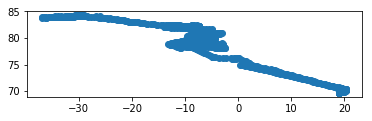

In [116]:
august.plot()

In [117]:
august.head()

,UTC date/time,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp,geometry
UTC date/time,,,,,,,,,,
2018-08-31 04:00:00,2018-08-31 04:00:00,DBLK,240,11.6631,NULL,998.2,-1.79999,-4.69999,-0.100012,POINT (-12 78.8)
2018-08-31 03:00:00,2018-08-31 03:00:00,DBLK,250,11.6631,NULL,998.1,-1.50001,-4.4,-0.799994,POINT (-11.6 78.8)
2018-08-31 02:00:00,2018-08-31 02:00:00,DBLK,260,9.71925,NULL,997.8,-1.4,-3.50001,-0.9,POINT (-11.1 78.8)
2018-08-31 01:00:00,2018-08-31 01:00:00,DBLK,260,11.6631,NULL,997.5,-1.29999,-3.69999,-0.500006,POINT (-10.6 78.8)
2018-08-31 00:00:00,2018-08-31 00:00:00,DBLK,270,13.60695,NULL,997,-1.00001,-3.50001,-0.100012,POINT (-10.1 78.8)


The tweet is about the Polarstern position at 2018-08-22 03:00:00:

In [118]:
toi = gdf.loc['2018-08-22 03:00:00']

toi

,UTC date/time,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp,geometry
UTC date/time,,,,,,,,,,
2018-08-22 03:00:00,2018-08-22 03:00:00,DBLK,270,7.7754,NULL,1005.2,-1.29999,-1.4,0.499994,POINT (-33.8 84)


In [119]:
wkt = toi['geometry'].values[0].wkt
wkt

'POINT (-33.8 84)'

Add map with boat position

In [123]:
global m

from ipyleaflet import Map, Polygon

m = Map(center=(toi['geometry'].values[0].centroid.y, 
                toi['geometry'].values[0].centroid.x), zoom=5)


marker = Marker(location=(toi['geometry'].values[0].centroid.y, 
                toi['geometry'].values[0].centroid.x), draggable=False)

m.add_layer(marker);

m


TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=


In [26]:
#august.apply(get_s1_reference, axis=1)

Convert the Polarstern AIS positions on 2018-08-22  to a line:

In [124]:
ais_track = LineString(list(gdf.loc['2018-08-22']['geometry'].values)).wkt

ais_track

'LINESTRING (-35.7 83.90000000000001, -36.1 83.8, -36.9 83.8, -36.2 83.8, -35.5 83.90000000000001, -34.8 83.90000000000001, -34 83.90000000000001, -33.3 84, -32.6 84, -31.9 84, -31.1 84, -30.3 84.09999999999999, -29.6 84.09999999999999, -28.8 84.09999999999999, -28.7 84.09999999999999, -30.2 84.09999999999999, -31.2 84, -32.1 84, -33 84, -33.8 84, -34.4 83.90000000000001, -35.3 83.90000000000001, -36.1 83.90000000000001)'

Add the Polarstern track on the 2018-08-22 to the map

In [128]:
aoi = Polygon(
    locations=np.asarray([t[::-1] for t in list(loads(ais_track).coords)]).tolist(),
    color="green",
    fill_color="green"
)

m += aoi

Search for Sentinel-1 acquisitions of the Polarstern track on 2018-08-22

In [129]:
start_time = '2018-08-22T00:00:00Z'
stop_time = '2018-08-22T23:59:59Z'

In [130]:
search_params = dict([('geom', ais_track),
                      ('start', start_time),
                      ('stop', stop_time),
                      ('pt', 'GRD')])

Create a geo data frame with the Sentinel-1 search results

In [131]:
ciop = cioppy.Cioppy()

series = 'https://catalog.terradue.com/sentinel1/search'

s1_results = GeoDataFrame(ciop.search(end_point=series, 
                     params=search_params,
                     output_fields='identifier,self,startdate,track,wkt,enclosure',
                     model='EOP'))


Set the _wkt_ as a geometry (it contains the Sentinel-1 footprints)

In [132]:
s1_results['wkt'] = s1_results['wkt'].apply(shapely.wkt.loads)

In [133]:
s1_results

,enclosure,identifier,self,startdate,track,wkt
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T181427_20180822T1815...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T18:14:27.7380000Z,103,"POLYGON ((-74.846138 83.50823200000001, -53.25..."
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T163558_20180822T1636...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T16:35:58.1460000Z,102,"POLYGON ((-42.295731 83.131958, -17.552143 86...."
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T145749_20180822T1458...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T14:57:49.7691180Z,101,"POLYGON ((-53.710899 83.771278, -66.315933 87...."
3,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T131947_20180822T1320...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T13:19:47.4270000Z,100,"POLYGON ((-49.95195 82.886047, -75.41834299999..."
4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,99,"POLYGON ((-37.121357 81.783356, -61.739033 84...."


In [134]:
list(s1_results.iloc[[0]]['wkt'])[0].exterior.coords

Add the Sentinel-1 footprints

In [135]:
global layer_group 

layer_group = LayerGroup(layers=())
m.add_layer(layer_group)

def f(x):
    layer_group.clear_layers()
    m.remove_layer(layer_group)
        
    p = Polygon(locations=np.asarray([t[::-1] for t in list(list(s1_results.iloc[[x]]['wkt'])[0].exterior.coords)]).tolist(), color="red", fill_color="green")
    
    d = {'identifier': list(s1_results.iloc[[x]]['identifier'])[0], 
         'track' :list(s1_results.iloc[[x]]['track'])[0]}
    
    html_value="""
        <div>
        <ul class='list-group'>
            <li class='list-group-item'>{identifier}</li>
            <li class='list-group-item'>{track}</li>
        </ul></div>""".format(**d)
    
    
    html_widget_slave = HTML(
            value=html_value,
    placeholder='',
    description='',
    )
    
    
    
    layer_group.add_layer(p)
    p.popup = html_widget_slave
    m.add_layer(layer_group)

In [136]:
interact(f, x=widgets.IntSlider(min=0,max=len(s1_results)-1,step=1,value=0));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J3gnLCBtYXg9NCksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnRlcmFjdCfigKY=


In [137]:
def analyse(row, aoi_wkt):

    aoi = loads(aoi_wkt)
    
    contains = row['wkt'].contains(aoi)
    
    series = dict([('contains', contains)])
    
    return pd.Series(series)
    

In [138]:
s1_results = s1_results.merge(s1_results.apply(lambda row: analyse(row, ais_track), axis=1), 
              left_index=True,
              right_index=True)

In [140]:
s1_results.head()

,enclosure,identifier,self,startdate,track,wkt,contains
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T181427_20180822T1815...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T18:14:27.7380000Z,103,"POLYGON ((-74.846138 83.50823200000001, -53.25...",False
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T163558_20180822T1636...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T16:35:58.1460000Z,102,"POLYGON ((-42.295731 83.131958, -17.552143 86....",False
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T145749_20180822T1458...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T14:57:49.7691180Z,101,"POLYGON ((-53.710899 83.771278, -66.315933 87....",True
3,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T131947_20180822T1320...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T13:19:47.4270000Z,100,"POLYGON ((-49.95195 82.886047, -75.41834299999...",True
4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",True


Select the Sentinel-1 acquisition with the index 4:

In [141]:
s1_results.iloc[4]

enclosure     https://store.terradue.com/download/sentinel1/...
identifier    S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...
self          https://catalog.terradue.com/sentinel1/search?...
startdate                          2018-08-22T11:41:38.6600000Z
track                                                        99
wkt           POLYGON ((-37.121357 81.783356, -61.739033 84....
contains                                                   True
Name: 4, dtype: object

The product is available for download at:

In [142]:
s1_results.iloc[4]['enclosure']

'https://store.terradue.com/download/sentinel1/files/v1/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770'

Download (stage-in) the selected Sentinel-1 product

In [143]:
ciop.copy(urls=s1_results.iloc[4]['enclosure'], extract=False, target='/data2')

'/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip'

Create a new geo data frame with the selected Sentinel-1 acquistion

In [144]:
s1_prd = GeoDataFrame(s1_results.iloc[4]).T

In [145]:
s1_prd

,enclosure,identifier,self,startdate,track,wkt,contains
4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",True


Add the local_path:

In [146]:
s1_prd['local_path'] = '/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip'

In [147]:
s1_prd

,enclosure,identifier,self,startdate,track,wkt,contains,local_path
4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",True,/data2/S1B_EW_GRDM_1SDH_20180822T114138_201808...


Save it as a CSV to be used for the generation of the backscatter:

In [148]:
s1_prd.to_pickle('s1_prd.picke')

In [149]:
list(s1_prd['local_path'])[0]

'/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip'

In [150]:
rgb_profile = """blue=Intensity_HH/Intensity_HV
name=rgb_profile
green=Intensity_HV
red=Intensity_HH"""

In [151]:
f = open('rgb_profile.rgb', 'w')
f.write(rgb_profile)
f.close()

In [152]:
options = ['/opt/snap/bin/pconvert',
           '-p',
           'rgb_profile.rgb',
           '-f',
            'png',
            '-o',
            '.',
           '-r',
           '1024,1024',
            list(s1_prd['local_path'])[0]]

p = subprocess.Popen(options,
    stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE)

print p.pid
res, err = p.communicate()
print res, err

8060
reading file /data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip
loading RGB profile from '/workspace/polarstern/rgb_profile.rgb'...
creating histogram for band 'Intensity_HH'...
creating histogram for band 'Intensity_HV'...
creating histogram for band 'virtual_blue'...
creating RGB image...
writing RGB image to './S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.png'...
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
SEVERE: org.esa.s2tbx.dataio.gdal.activator.GDALDistributionInstaller: The environment variable LD_LIBRARY_PATH is not set. It must contain the current folder '.'.
INFO: org.hsqldb.persist.Logger: dataFileCache open start



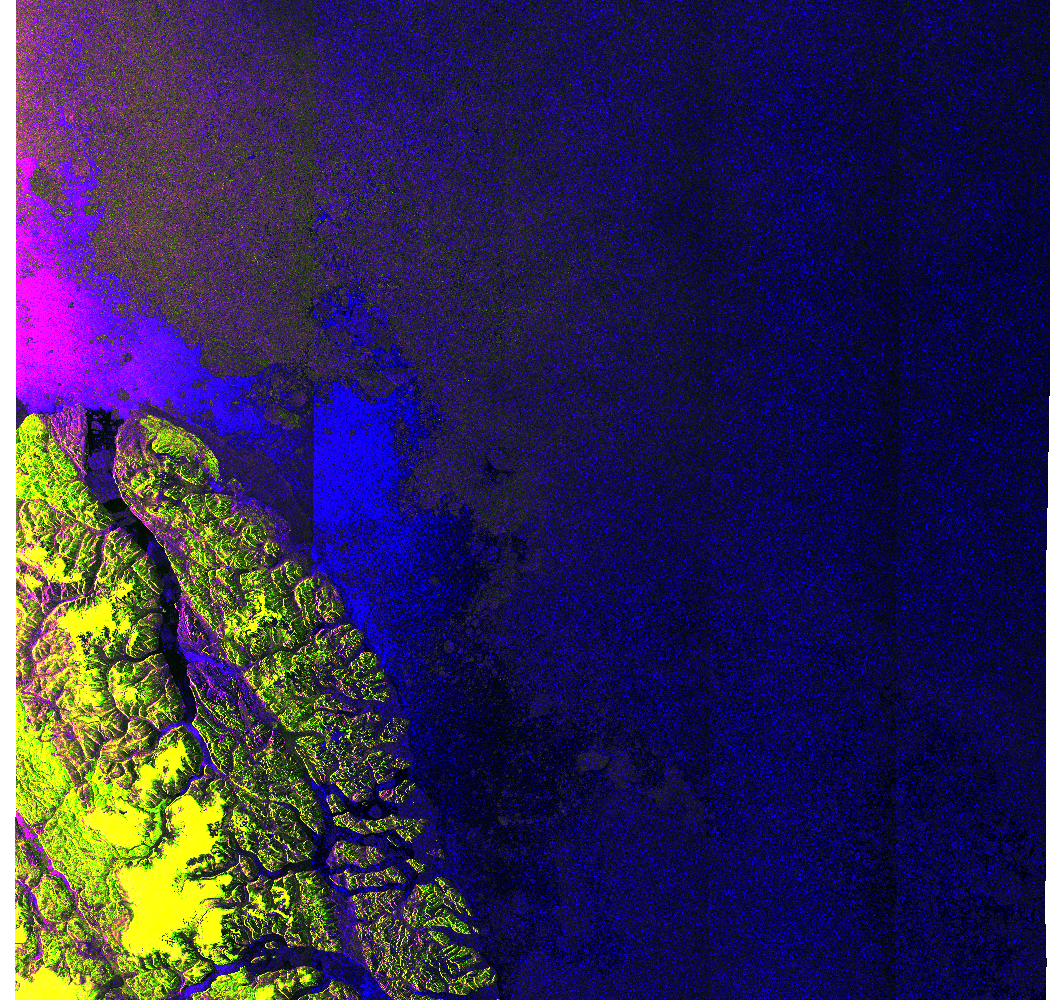

In [154]:
from IPython.display import Image
Image(filename=s1_results.iloc[4]['identifier'] + '.png') 